# IceCube Upgrade neutrino MC release

The following notebook shows simple examples of how to load and use this data release. 

Please note that simple toy flux and oscillation models are used throughout these examples, and as such the resulting plots are intended only for demonstration purposes.

Questions can be directed to data@icecube.wisc.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'lines.linewidth': 3})
matplotlib.rcParams.update({'patch.linewidth': 3})

## Load the data

The data is stored as a CSV file. Here we use the popular `pandas` library to load, although many other CSV parsing techniques are available.

In [2]:
# Define path to file (you may need to change this to match your system)
input_file = "neutrino_mc.csv"

# Load the file using pandas
input_data = pd.read_csv(input_file)

# Display the data
input_data

,pdg,pid,true_energy,true_zenith,true_azimuth,reco_energy,reco_zenith,reco_azimuth,interaction_type,current_type,weight,xsec,dxsec,x,y,W,Q2
0,12,0,3.46,2.190,1.07,4.97,2.290,1.45,1,1,8.980000e-09,0.782,5.68,0.0879,0.1130,1.250,0.0648
1,12,0,12.30,1.550,5.39,13.20,1.450,5.86,2,1,2.180000e-07,70.200,116.00,0.4470,0.5520,2.820,5.7100
2,12,0,12.30,1.640,1.13,14.60,1.500,1.23,2,1,2.170000e-07,69.900,138.00,0.1020,0.7410,4.030,1.7400
3,12,0,4.15,1.640,5.62,6.37,1.650,5.62,1,1,1.290000e-08,6.260,44.50,0.3510,0.1140,1.210,0.3130
4,12,0,1.89,2.170,3.33,2.88,2.070,3.16,0,1,1.450000e-09,7.600,1.11,2.0600,0.0374,0.861,0.2730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271778,-16,0,47.60,1.900,2.99,20.10,0.851,3.01,2,0,9.600000e-06,1.080,6.61,0.1150,0.1130,3.130,1.1600
271779,-16,1,51.00,1.620,1.91,31.50,1.260,1.70,2,0,1.150000e-05,4.790,22.80,0.0833,0.6940,7.870,5.5500
271780,-16,0,124.00,1.550,2.61,37.50,1.850,2.69,2,0,1.170000e-04,50.000,86.30,0.3360,0.2990,6.870,23.4000
271781,-16,0,16.70,0.323,2.23,12.70,0.867,2.60,2,0,6.590000e-07,2.920,1.49,0.2230,0.7280,4.310,5.0900


## Using the event weights

The `weight` provided for each event encodes information about the neutrino simulation, including the neutrino-ice interactions. They do not include the neutrino flux, neutrino oscillations, or other information that depends upon the physics hypothesis being tested. A user must therefore multiply these weights by a flux to obtain a weighted neutrino disribution in Hz. This can be further multiplied by a detector expoosure time to obtain expected event counts.

The next few code blocks show how to use the event weights.

In [3]:
# Defining a few useful thing sbefore we get started...

# Define some energy bins (used throughout this notebook)
energy_bins_fine = np.logspace(0., 2., num=21)
energy_bins_course = np.logspace(0., 2., num=11)

# Define masks to identify different neutrino flavors
nue_mask = (np.abs(input_data["pdg"]) == 12)
numu_mask = (np.abs(input_data["pdg"]) == 14)
nutau_mask = (np.abs(input_data["pdg"]) == 16)

# It is often desirable to seperate the neutrinos by flavor and interaction.
# It is common to consider all Neutral Current (NC) interactions together, as 
# there is no final state charged lepton with which to discriminate the different 
# neutrino flavors.
# Define masks to identify different flavor/interaction combinations.
nc_mask = input_data["current_type"] == 0
cc_mask = input_data["current_type"] == 1
nue_cc_mask = nue_mask & cc_mask
numu_cc_mask = numu_mask & cc_mask
nutau_cc_mask = nutau_mask & cc_mask

### Calculating effective area

Effective areas a commonly meausure of the detector efficiency to a given type of event. 

Here we show how to use the `weight` variable provided to compute effective area. Note that we do not need to include a physics hypothesis here (e.g. no flux or oscillations assumed). We plot the effective area w.r.t. (binned) energy.

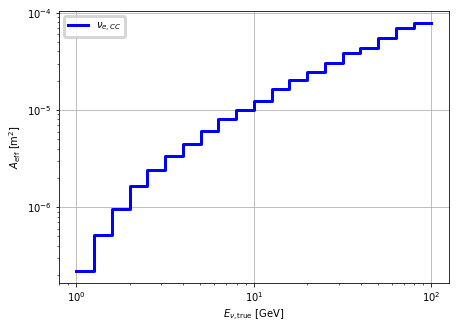

In [4]:

# Choosing nue CC events as an example
chosen_mask = nue_cc_mask

# Calc effective area
effective_area_hist, bin_edges = np.histogram(input_data["true_energy"][chosen_mask], weights=input_data["weight"][chosen_mask], bins=energy_bins_fine )
effective_area_hist /= 4. * np.pi # Normalise by solid angle (using the fully sky)
effective_area_hist /= np.diff(bin_edges) # Bin widths

# Plot
fig, ax = plt.subplots(figsize=(7,5))
ax.step( bin_edges, effective_area_hist.tolist()+[effective_area_hist[-1]], where="post", color="blue", label=r"$\nu_{e,CC}$" )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_ylabel(r"$A_{\rm{eff}}$ [$\rm{m^2}$]")
ax.grid(True)
_ = ax.legend()

### Creating a toy atmopsheric neutrino flux

For demonstration purposes, here we show a simple example of weighting events to a toy atmospheric neutrino spectrum (the dominant source of neutrinos in the IceCube Upgrade), including the effects of neutrino oscillations.

We define a toy conventional atmospheric neutrino flux, $\Phi$, using a power law with normalisation and spectral index chosen to be in the same ballpark w.r.t energy as more realistic models (integrated over arrival direction).

There is no nutau flux here (neglecting prompt production).

This toy model is for demonstration purposes only, more sophisticated flux models such as those provided by `MCEq` (https://github.com/afedynitch/MCEq) or Honda et al. (PhysRevD.92.023004) are available.

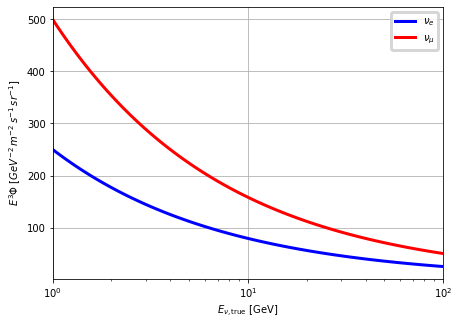

In [5]:
# Function to generate a toy atmopsheric neutrino flux
def atmo_nu_flux(true_energy) :
    numu_flux = 5e2 * np.power(true_energy, -3.5)
    nue_flux = numu_flux / 2.
    return nue_flux, numu_flux

# Plot the toy flux vs energy.
# Note that in reality the atmospheric flux also varies significantly as a function 
# of direction, but neglecting this in this toy example.
# Note that plotting as E^3 * flux for visual clarify
energy_vals = np.logspace(0., 2., num=100)
plot_energy_power = 3
nue_flux, numu_flux = atmo_nu_flux(energy_vals)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(energy_vals, np.power(energy_vals, plot_energy_power)*nue_flux, label=r"$\nu_{e}$", color="blue")
ax.plot(energy_vals, np.power(energy_vals, plot_energy_power)*numu_flux, label=r"$\nu_{\mu}$", color="red")
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_xlim(energy_vals[0], energy_vals[-1])
ax.set_xscale("log")
ax.set_ylabel(r"$E^{%0.3g} \Phi$ $[GeV^{-%0.3g} \, m^{-2} \, s^{-1} \, sr^{-1} ]$" % ( plot_energy_power, plot_energy_power-1. ))
ax.grid(True)
_ = ax.legend()

### Compute oscillation transition probability

We also account for neutrino oscillations in our weights. For demonstration purposes, here we assume 2 flavor atmospheric ($\mu \rightarrow \tau$) oscillations in vacuum. Approximate values for the atmopsheric mixing angle and mass splitting are used.

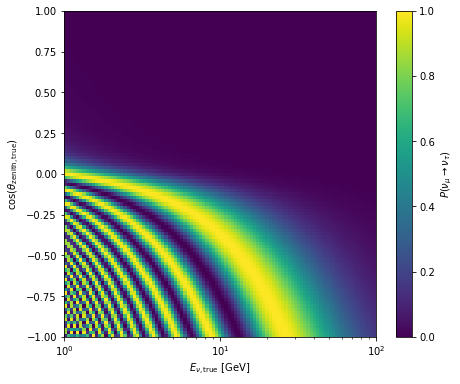

In [6]:
# Define a function to compute transition probability
def mu_tau_osc_prob(true_energy, true_zenith) :
    
    # Get baseline [km] (propagation distance) from zenith angle
    # Unit is km
    true_coszen = np.cos(true_zenith)
    earth_radius = 6371.
    production_height = 15. # Assuming neutrino produced 15 km above surface
    detector_depth = 1. # Assuming detector depth of 1 km
    baseline = -earth_radius*true_coszen +  np.sqrt( (earth_radius*true_coszen)**2 - earth_radius**2 + (earth_radius+production_height+detector_depth)**2 )

    # Compute oscillation transition probability
    theta = np.deg2rad(45.) # Maximal mixing
    deltam2 = 2.5e-3
    Pmutau = ( np.sin(2.*theta)**2 ) * np.sin( ( 1.27 * deltam2 * baseline ) / true_energy )**2.
    
    return Pmutau


# Plot the oscillation probability vs energy and cos(zenith) angle
energy_grid, coszen_grid = np.meshgrid(np.logspace(0., 2., num=100), np.linspace(-1., 1., num=100), indexing="ij")
Pmutau_grid = mu_tau_osc_prob(energy_grid, np.arccos(coszen_grid) )
fig, ax = plt.subplots(figsize=(7,6))
cmesh = ax.pcolormesh(energy_grid, coszen_grid, Pmutau_grid, vmin=0., vmax=1.)
fig.colorbar(cmesh, ax=ax, label=r"$P(\nu_\mu \rightarrow \nu_\tau$)")
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_xscale("log")
_ = ax.set_ylabel(r"$\cos(\theta_{\rm{zenith,true}})$")

### Compute weights

Can now compute event weights given our toy atmopsheric neutrino flux + oscillations model.

In [7]:
# Get fluxes
nue_flux, numu_flux = atmo_nu_flux(input_data["true_energy"])

# Get oscillations
Pmutau = mu_tau_osc_prob(input_data["true_energy"], input_data["true_zenith"])

# Now compute weights representing event rates
# This is flux * osc * weight
rate_weight = np.zeros_like(input_data["weight"])
rate_weight[nue_mask] = nue_flux[nue_mask] * input_data["weight"][nue_mask] # No oscillations in 2 flavor model
rate_weight[numu_mask] = numu_flux[numu_mask] * (1. - Pmutau[numu_mask]) * input_data["weight"][numu_mask] # numu flux, less those that oscillation
rate_weight[nutau_mask] = numu_flux[nutau_mask] * Pmutau[nutau_mask] * input_data["weight"][nutau_mask] # nutau purely come from oscillations in the numu flux
input_data["rate_weight"] = rate_weight

# The sum of the rate weights gives the overall total neutrino rate
print("Total neutrino rate = %0.3g mHz" % (np.nansum(rate_weight) * 1e3) )

Total neutrino rate = 3.08 mHz


### Plotting weighted event distributions

Here we show an event of plotting the detected neutrino rate in the IceCube Upgrade, given the weights we computed using our toy flux and oscillations. We plot this as a function of energy.

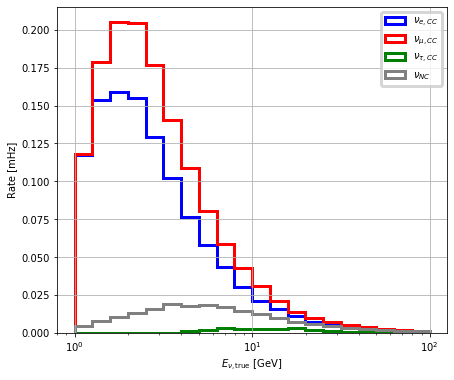

In [8]:
# Plot histograms of event rates vs energy
# Note that converting to mHz for the rate, as this is a more suitable unit for the IceCube Upgrade 
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(input_data["true_energy"][nue_cc_mask], bins=energy_bins_fine, weights=(1e3)*input_data["rate_weight"][nue_cc_mask], label=r"$\nu_{e,CC}$", color="blue", histtype="step")
ax.hist(input_data["true_energy"][numu_cc_mask], bins=energy_bins_fine, weights=(1e3)*input_data["rate_weight"][numu_cc_mask], label=r"$\nu_{\mu,CC}$", color="red", histtype="step")
ax.hist(input_data["true_energy"][nutau_cc_mask], bins=energy_bins_fine, weights=(1e3)*input_data["rate_weight"][nutau_cc_mask], label=r"$\nu_{\tau,CC}$", color="green", histtype="step")
ax.hist(input_data["true_energy"][nc_mask], bins=energy_bins_fine, weights=(1e3)*input_data["rate_weight"][nc_mask], label=r"$\nu_{NC}$", color="grey", histtype="step")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_ylabel("Rate [mHz]")
ax.grid(True)
_ = ax.legend()

## Reconstruction resolution

Here we plot the reconstructed vs true neutrino parameters to show the resolution of the IceCube Upgrade. The detector resolution improves with increasing neutrino energy, and can vary both in terms of resolution and bias for different flavors and interactions. For example, interactions with final state neutrinos have "missing energy", impacting reconstruction.

Here we plot the reconstruction error for the neutrino energy, zenith angle and azimuth angle. The spread of these distributions is the reconsutruction resolution. Additionally, any biases (e.g. asymmetric distributions) can be observed in plots of this nature.

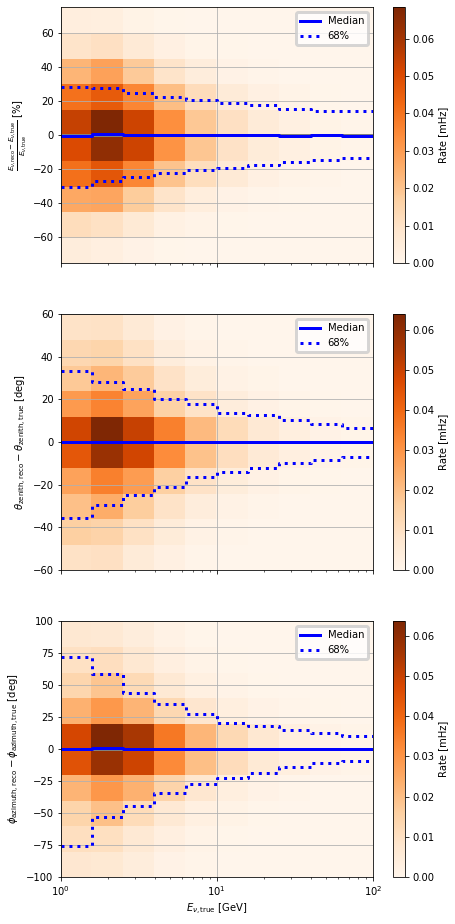

In [9]:
#
# Get reco error
#

# Calculate the reconstruction error for each event
# It is clearest to show fractional error for energy and absolute error for direction
reco_energy_frac_error = ( input_data["reco_energy"] - input_data["true_energy"] ) / input_data["true_energy"]
reco_zenith_error = input_data["reco_zenith"] - input_data["true_zenith"]
reco_azimuth_error = input_data["reco_azimuth"] - input_data["true_azimuth"]

# Convert to nice plotting units
reco_energy_frac_error *= 100. # -> %
reco_zenith_error = np.rad2deg(reco_zenith_error) # [deg]
reco_azimuth_error = np.rad2deg(reco_azimuth_error) # [deg]

# Plot histograms of the reconstruction error vs energy
# Here showing the performance for nue CC events only as an example
chosen_mask = nue_cc_mask
fig, ax = plt.subplots(3, figsize=(7,16), sharex=True)
_,_,_,img = ax[0].hist2d(input_data["true_energy"][chosen_mask], reco_energy_frac_error[chosen_mask], bins=[energy_bins_course, np.linspace(-75., +75., num=11)], weights=(1e3)*input_data["rate_weight"][chosen_mask], cmap="Oranges")
fig.colorbar(img, ax=ax[0], label="Rate [mHz]")
_,_,_,img = ax[1].hist2d(input_data["true_energy"][chosen_mask], reco_zenith_error[chosen_mask], bins=[energy_bins_course, np.linspace(-60., +60., num=11)], weights=(1e3)*input_data["rate_weight"][chosen_mask], cmap="Oranges")
fig.colorbar(img, ax=ax[1], label="Rate [mHz]")
_,_,_,img = ax[2].hist2d(input_data["true_energy"][chosen_mask], reco_azimuth_error[chosen_mask], bins=[energy_bins_course, np.linspace(-100., +100., num=11)], weights=(1e3)*input_data["rate_weight"][chosen_mask], cmap="Oranges")
fig.colorbar(img, ax=ax[2], label="Rate [mHz]")
for axi in ax :
    axi.set_xscale("log")
    axi.grid(True)
    axi.axhline(0., color="grey") # Add line marking "perfect reconstruction"
ax[0].set_ylabel(r"$\frac{ E_{\nu,\rm{reco}} - E_{\nu,\rm{true}} }{ E_{\nu,\rm{true}} }$ [%]")
ax[1].set_ylabel(r"$\theta_{\rm{zenith},\rm{reco}} - \theta_{\rm{zenith},\rm{true}}$ [deg]")
ax[2].set_ylabel(r"$\phi_{\rm{azimuth},\rm{reco}} - \phi_{\rm{azimuth},\rm{true}}$ [deg]")
_ = ax[-1].set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")


#
# Get reco error percentiles
#

# Also helpful to compute percentiles of the reco error distributons.
# The median (50%) percentile can be used to look for bias (ideally the median error = 0).
# The interval [16%, 84%] contains 68% of the events, so under the (over simplified) assumption
# of a Gaussian distribution this can be considered as the 1 sigma interval.

# Function to compute relevent percentiles
# Do this as a function of (binned) energy, as reconstruction performance improves with energy
def resolution_percentiles(energy_bins, true_energy, reco_error) :
    indices = np.digitize(true_energy, energy_bins)
    percentiles = []
    for i in range(1, energy_bins.size) :
        percentiles.append( np.percentile(reco_error[indices==i], [16.,50.,84.]) ) 
    return np.array(percentiles)

# Compute the percentiles (as a function of energy)
energy_percentiles = resolution_percentiles(energy_bins_course, input_data["true_energy"][chosen_mask], reco_energy_frac_error[chosen_mask])
zenith_percentiles = resolution_percentiles(energy_bins_course, input_data["true_energy"][chosen_mask], reco_zenith_error[chosen_mask])
azimuth_percentiles = resolution_percentiles(energy_bins_course, input_data["true_energy"][chosen_mask], reco_azimuth_error[chosen_mask])

# Percentile plotting function
def plot_percentiles(energy_bins, percentiles, ax) :
    ax.step( energy_bins, percentiles[:,1].tolist()+[percentiles[-1,1]], where="post", color="blue", linestyle="-", label="Median" )
    ax.step( energy_bins, percentiles[:,0].tolist()+[percentiles[-1,0]], where="post", color="blue", linestyle=":", label="68%" )
    ax.step( energy_bins, percentiles[:,2].tolist()+[percentiles[-1,2]], where="post", color="blue", linestyle=":", label=None )

# Overlay the percentiles on the plots
plot_percentiles( energy_bins_course, energy_percentiles, ax[0] )
plot_percentiles( energy_bins_course, zenith_percentiles, ax[1] )
plot_percentiles( energy_bins_course, azimuth_percentiles, ax[2] )
for axi in ax :
    axi.legend()

## PID performance

Here we plot the accuracy of the Particle IDentification (PID). The accuracy improves with increasing neutrino energy. 

Two event topologies are defined; tracks and cascades. Track events are those containing a muon travelling a significant distance in the detector, and are a proxy for Charged Current (CC) numu events.

/Users/stuttard/physics/icecube/software/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


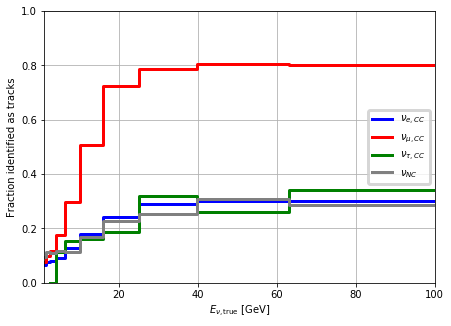

In [10]:
# Get masks identifying tracks vs cascades
cascade_mask = input_data["pid"] == 0
track_mask = input_data["pid"] == 1

# Get mask identifying numu CC that are identified as tracks
numu_cc_track_mask = numu_cc_mask & track_mask

# Also plot other flavors/interactions (which are more cascade-like) for comparison
nue_cc_track_mask = nue_cc_mask & track_mask
nutau_cc_track_mask = nutau_cc_mask & track_mask
nc_track_mask = nc_mask & track_mask

# Plot fraction of events identified as tracks (vs energy)
def plot_track_fraction(flavint_mask, flavint_track_mask, label, color) :
    flavint_hist, _ = np.histogram( input_data["true_energy"][flavint_mask], bins=energy_bins_course, weights=input_data["rate_weight"][flavint_mask] )
    flavint_track_hist, _ = np.histogram( input_data["true_energy"][flavint_track_mask], bins=energy_bins_course, weights=input_data["rate_weight"][flavint_track_mask] )
    track_fraction = flavint_track_hist.astype(float) / flavint_hist.astype(float)
    ax.step(energy_bins_course, np.append([track_fraction[0]], track_fraction), color=color, label=label)

fig, ax = plt.subplots(figsize=(7,5))
plot_track_fraction(flavint_mask=nue_cc_mask, flavint_track_mask=nue_cc_track_mask, color="blue", label=r"$\nu_{e,CC}$")
plot_track_fraction(flavint_mask=numu_cc_mask, flavint_track_mask=numu_cc_track_mask, color="red", label=r"$\nu_{\mu,CC}$")
plot_track_fraction(flavint_mask=nutau_cc_mask, flavint_track_mask=nutau_cc_track_mask, color="green", label=r"$\nu_{\tau,CC}$")
plot_track_fraction(flavint_mask=nc_mask, flavint_track_mask=nc_track_mask, color="grey", label=r"$\nu_{NC}$")
# ax.set_xscale("log")
ax.set_ylabel(r"Fraction identified as tracks")
ax.set_ylim(0., 1.)
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_xlim(energy_bins_course[0], energy_bins_course[-1])
ax.grid(True)
_ = ax.legend()

## Neutrino interactions

The following example demonstrates the contibutions from various interaction channels present the IceCube Upgrade, using our toy flux model.

However, note that this depends strongly on the observed neutrino flux (particularly below 10 GeV), and so this is only shown for demonstration purposes.

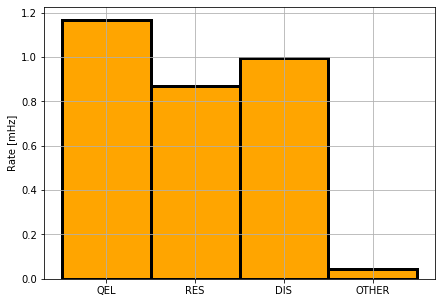

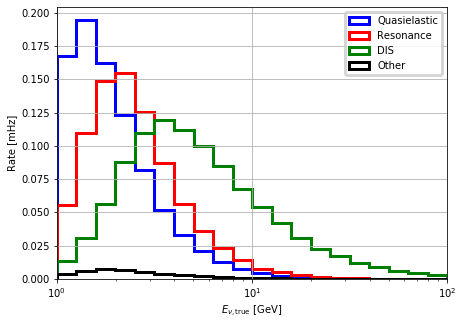

In [11]:
# Plot histogram of contributions from various interaction channels
# This is showing all neutrino types, currents, energies, etc integrated
fig, ax = plt.subplots(figsize=(7,5))
interaction_bins = np.linspace(-0.5, 3.5, num=5)
ax.hist(input_data["interaction_type"], bins=interaction_bins, weights=1e3*input_data["rate_weight"], color="orange", edgecolor="black", histtype="bar")
ax.grid()
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["QEL", "RES", "DIS", "OTHER"])
_ = ax.set_ylabel("Rate [mHz]")

# Show energy distribution for different interaction types
fig, ax = plt.subplots(figsize=(7,5))
qel_mask = input_data["interaction_type"] == 0
res_mask = input_data["interaction_type"] == 1
dis_mask = input_data["interaction_type"] == 2
other_mask = input_data["interaction_type"] == 3
ax.hist(input_data["true_energy"][qel_mask], bins=energy_bins_fine, weights=1e3*input_data["rate_weight"][qel_mask], label="Quasielastic", color="blue", histtype="step")
ax.hist(input_data["true_energy"][res_mask], bins=energy_bins_fine, weights=1e3*input_data["rate_weight"][res_mask], label="Resonance", color="red", histtype="step")
ax.hist(input_data["true_energy"][dis_mask], bins=energy_bins_fine, weights=1e3*input_data["rate_weight"][dis_mask], label="DIS", color="green", histtype="step")
ax.hist(input_data["true_energy"][other_mask], bins=energy_bins_fine, weights=1e3*input_data["rate_weight"][other_mask], label="Other", color="black", histtype="step")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu,\rm{true}}$ [GeV]")
ax.set_ylabel("Rate [mHz]")
ax.set_xlim(energy_bins_course[0], energy_bins_course[-1])
ax.grid(True)
_ = ax.legend()